In [1]:
import reactord as rd
import reactord.flowreactors.stationary_1d.pfr as pfr

import numpy as np

import matplotlib.pyplot as plt

### Definicion de las substancias

In [2]:
a = rd.Substance.from_thermo_database(
    name="methane", thermo_identification="methane"
)
b = rd.Substance.from_thermo_database(
    name="ethane", thermo_identification="ethane"
)
c = rd.Substance.from_thermo_database(
    name="hydrogen", thermo_identification="hydrogen"
)

### Definicion de la mezcla

In [3]:
mix = rd.mix.IdealGas([a, b, c])

### Definicion de kinetics

In [4]:
def ra(concentrations, temperature):
    ra = 0.05 * concentrations[0]
    return ra


stoichiometry = np.array([-2, 1, 1])

kinetic = rd.Kinetics(mix, [ra], stoichiometry)

### Definicion de balances

In [5]:
mb = pfr.mass_balances.MolarFlow(
    molar_flows_in={"methane": 0.01, "ethane": 0, "hydrogen": 0},
    molar_flows_out={},
)

eb = pfr.energy_balances.Isothermic(400)

pb = pfr.pressure_balances.Isobaric(1_000_000)

### Definicion del reactor

In [6]:
reactor1 = pfr.PFR(
    mix=mix,
    kinetics=kinetic,
    reactor_length=0.02,
    transversal_area=0.05,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb,
)

### El repr() del reactor te devuelve el latex de los balances

In [7]:
reactor1

\frac{1}{a_t}\frac{dF_i}{dz}=r_i
\frac{dT}{dz}=0
\frac{dT_r}{dz}=0
\frac{dP}{dz}=0

### El irepr del reactor te renderiza los latex si estas en un entorno interactivo

In [8]:
reactor1.irepr

Mass balance:


\frac{1}{a_t}\frac{dF_i}{dz}=r_i

Reactor and refrigerant energy balances:


\frac{dT}{dz}=0

\frac{dT_r}{dz}=0

Pressure balance:


\frac{dP}{dz}=0

### Simulamos el reactor

In [9]:
reactor1 = pfr.PFR(
    mix=mix,
    kinetics=kinetic,
    reactor_length=0.02,
    transversal_area=0.05,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb,
)

In [18]:
reactor1.simulate(tol=0.001, max_nodes=100, verbose=1)

Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 2.69e-06 
Maximum boundary residual: 5.20e-18


In [11]:
reactor1.sim_df

,z,methane,ethane,hydrogen,temperature,pressure
0,0.000000,0.010000,0.000000,0.000000,400.0,1000000.0
1,0.000202,0.009701,0.000150,0.000150,400.0,1000000.0
2,0.000404,0.009411,0.000295,0.000295,400.0,1000000.0
3,0.000606,0.009129,0.000435,0.000435,400.0,1000000.0
4,0.000808,0.008856,0.000572,0.000572,400.0,1000000.0
...,...,...,...,...,...,...
95,0.019192,0.000558,0.004721,0.004721,400.0,1000000.0
96,0.019394,0.000542,0.004729,0.004729,400.0,1000000.0
97,0.019596,0.000525,0.004737,0.004737,400.0,1000000.0
98,0.019798,0.000510,0.004745,0.004745,400.0,1000000.0


### Ergun pressure balance

In [12]:
mb = pfr.mass_balances.MolarFlow(
    molar_flows_in={"methane": 0.01, "ethane": 0, "hydrogen": 0},
    molar_flows_out={},
)

eb = pfr.energy_balances.Isothermic(400)

pb = pfr.pressure_balances.Ergun(
    pressure={"in": 1_000_000}, porosity=0.05, particle_diameter=0.001
)

reactor2 = pfr.PFR(
    mix=mix,
    kinetics=kinetic,
    reactor_length=0.02,
    transversal_area=0.05,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb,
)

In [13]:
reactor2.irepr

Mass balance:


\frac{1}{a_t}\frac{dF_i}{dz}=r_i

Reactor and refrigerant energy balances:


\frac{dT}{dz}=0

\frac{dT_r}{dz}=0

Pressure balance:


\frac{dP}{dz}=-\frac{G}{{\rho}D_p}\left(\frac{1-\phi}{\phi^3}\right)\left[\frac{150(1-\phi)\mu}{D_p}+1.75G\right]

In [14]:
reactor2.simulate(tol=0.001, max_nodes=1000, verbose=1)

Solved in 1 iterations, number of nodes 100. 
Maximum relative residual: 1.37e-07 
Maximum boundary residual: 0.00e+00


In [15]:
reactor2.sim_df

,z,methane,ethane,hydrogen,temperature,pressure
0,0.000000,0.010000,0.000000,0.000000,400.0,1000000.000000
1,0.000202,0.009701,0.000150,0.000150,400.0,999999.997924
2,0.000404,0.009411,0.000295,0.000295,400.0,999999.995856
3,0.000606,0.009129,0.000435,0.000435,400.0,999999.993796
4,0.000808,0.008856,0.000572,0.000572,400.0,999999.991745
...,...,...,...,...,...,...
95,0.019192,0.000558,0.004721,0.004721,400.0,999999.823179
96,0.019394,0.000542,0.004729,0.004729,400.0,999999.821415
97,0.019596,0.000525,0.004737,0.004737,400.0,999999.819652
98,0.019798,0.000510,0.004745,0.004745,400.0,999999.817889


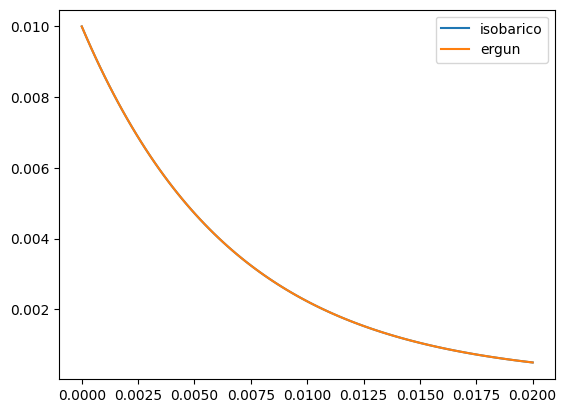

In [16]:
plt.plot(reactor1.sim_df["z"], reactor1.sim_df["methane"], label="isobarico")
plt.plot(reactor2.sim_df["z"], reactor2.sim_df["methane"], label="ergun")

plt.legend()

In [1]:
import numpy as np

In [4]:
m = np.array(
    [
        [1,2,3,4,5],
        [1,2,3,4,5],
        [1,2,3,4,5],
        [1,2,3,4,5],
    ]
)

d = {"a": 0, "b": 1}

In [1]:
import reactord as rd

In [2]:
a = rd.Substance.from_thermo_database("CH_4", "methane")
b = rd.Substance.from_thermo_database("O_2", "oxygen")
c = rd.Substance.from_thermo_database("CO_2", "carbon dioxide")
d = rd.Substance.from_thermo_database("CO", "carbon monoxide")
e = rd.Substance.from_thermo_database("H_{2}O", "water")

mix = rd.mix.IdealGas([a,b,c,d,e])

def rate_r1(c, t, **constants):
    a, b = constants.get("a"), constants.get("b")
    ...
    
def rate_r2():
    ...

kinetic = rd.kinetic.Kinetic(
    mix,
    {
        "r1": {
            "eq": a + 2 * b > c + 2 * e,
            "rate": rate_r1
        },
        "r2": {
            "eq": a + 3 / 2 * b > d + 2 * e,
            "rate": rate_r2
        }
    },
    kinetic_constants = {}
)

In [3]:
kinetic.stoichiometry

array([[-1. , -2. ,  1. ,  0. ,  2. ],
       [-1. , -1.5,  0. ,  1. ,  2. ]])

In [4]:
kinetic.irepr

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
kinetic

Mixture's substances: 
  * CH_4 
  * O_2 
  * CO_2 
  * CO 
  * H_{2}O 

System's reactions: 
r1: CH_{4} + 2 O_{2} \rightarrow CO_{2} + 2 H_{2}O 
r2: CH_{4} + 1.5 O_{2} \rightarrow CO + 2 H_{2}O 